# Customer Analysis and Retention Insights

This analysis focuses on customer-level data to understand demographics, purchasing behavior, and retention patterns.  
The objective is to identify high-value customer segments and behavioral indicators that can inform retention and engagement strategies.


## Data Loading and Initial Inspection

We begin by loading the customer dataset and reviewing its structure, data types, and overall completeness.


In [4]:
import pandas as pd

customer_df = pd.read_excel("customer.xlsx")
customer_df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
customer_df.info()
customer_df.describe(include="all")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
count,541909.0,541909,540455,541909.000000,541909,541909.000000,406829.000000,541909
unique,25900.0,4070,4223,NaN,NaN,NaN,NaN,38
top,573585.0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,NaN,NaN,NaN,United Kingdom
freq,1114.0,2313,2369,NaN,NaN,NaN,NaN,495478
mean,NaN,NaN,NaN,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570,NaN
min,NaN,NaN,NaN,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000,NaN
25%,NaN,NaN,NaN,1.000000,2011-03-28 11:34:00,1.250000,13953.000000,NaN
50%,NaN,NaN,NaN,3.000000,2011-07-19 17:17:00,2.080000,15152.000000,NaN
75%,NaN,NaN,NaN,10.000000,2011-10-19 11:27:00,4.130000,16791.000000,NaN
max,NaN,NaN,NaN,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000,NaN


## Data Quality Assessment

We examine missing values and data consistency to determine appropriate cleaning strategies before analysis.


In [6]:
customer_df.isnull().sum()


,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


In [7]:
# Example: handle missing values
customer_df = customer_df.dropna()

# Remove duplicates if any
customer_df = customer_df.drop_duplicates()


## Customer-Level Feature Engineering

The original dataset is transaction-level (each row is a line item). For customer analysis, we aggregate transactions to build a customer-level table.

We derive the following metrics:
- **TotalSpend**: total revenue contributed by the customer
- **Frequency**: number of unique invoices (proxy for purchase frequency)
- **Recency**: days since the customer’s last purchase (lower is better)
- **RepeatCustomer**: a simple retention proxy based on Frequency
- **ValueSegment**: spend-based tiers for targeted strategies


In [11]:
import datetime as dt

# Copy and clean: keep only valid sales transactions and customers
cust_tx = customer_df.copy()
cust_tx['Revenue'] = cust_tx['Quantity'] * cust_tx['UnitPrice']

cust_tx = cust_tx[(cust_tx['Quantity'] > 0) & (cust_tx['UnitPrice'] > 0)].dropna(subset=['CustomerID']).copy()

# Snapshot date used for recency calculation
snapshot_date = cust_tx['InvoiceDate'].max() + dt.timedelta(days=1)

# Customer-level table
customer_level = cust_tx.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'Revenue': 'sum',
    'Country': lambda x: x.mode().iat[0] if not x.mode().empty else x.iloc[0]
}).reset_index()

customer_level.columns = ['CustomerID', 'Recency', 'Frequency', 'TotalSpend', 'Country']

# Repeat customer flag (retention proxy)
customer_level['RepeatCustomer'] = customer_level['Frequency'] > 1

# Value segmentation by spend
customer_level['ValueSegment'] = pd.qcut(
    customer_level['TotalSpend'],
    q=3,
    labels=['Low Value', 'Medium Value', 'High Value']
)

customer_level.head()

,CustomerID,Recency,Frequency,TotalSpend,Country,RepeatCustomer,ValueSegment
0,12346.0,326,1,77183.60,United Kingdom,False,High Value
1,12347.0,2,7,4310.00,Iceland,True,High Value
2,12348.0,75,4,1797.24,Finland,True,High Value
3,12349.0,19,1,1757.55,Italy,False,High Value
4,12350.0,310,1,334.40,Norway,False,Low Value


Missing values and duplicate records were removed to ensure accurate customer-level analysis.


## Customer Demographics

This section explores the demographic characteristics of customers, such as age, gender, and location, to understand the composition of the customer base.


In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

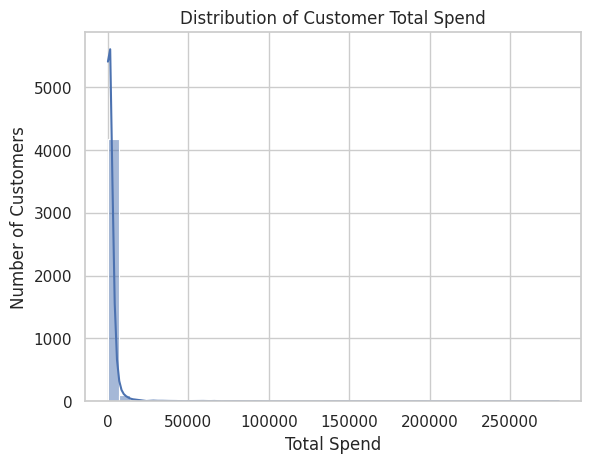

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(customer_level['TotalSpend'], bins=40, kde=True)
plt.title('Distribution of Customer Total Spend')
plt.xlabel('Total Spend')
plt.ylabel('Number of Customers')
plt.show()

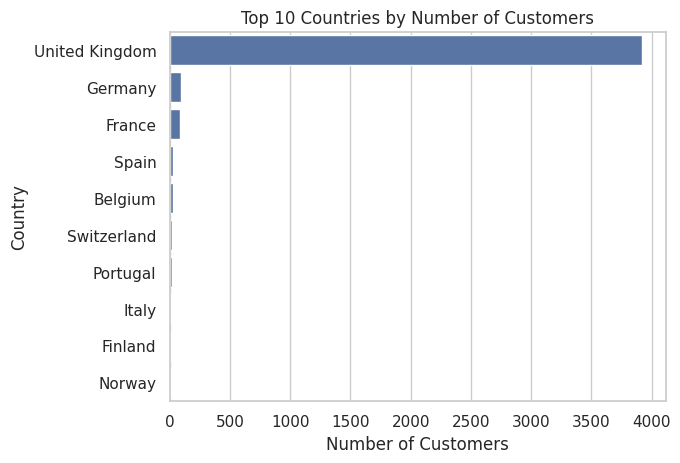

In [14]:
top_countries = customer_level['Country'].value_counts().head(10)

sns.barplot(x=top_countries.values, y=top_countries.index)
plt.title('Top 10 Countries by Number of Customers')
plt.xlabel('Number of Customers')
plt.ylabel('Country')
plt.show()

In [15]:
customer_level['Country'].value_counts().head(10)

,count
Country,
United Kingdom,3920
Germany,94
France,87
Spain,29
Belgium,24
Switzerland,20
Portugal,19
Italy,14
Finland,12


## Customer Behavior Analysis

We analyze purchasing behavior to understand spending patterns, engagement levels, and repeat purchase tendencies.


In [16]:
customer_level['TotalSpend'].describe()

,TotalSpend
count,4338.000000
mean,2048.688081
std,8985.230220
min,3.750000
25%,306.482500
50%,668.570000
75%,1660.597500
max,280206.020000


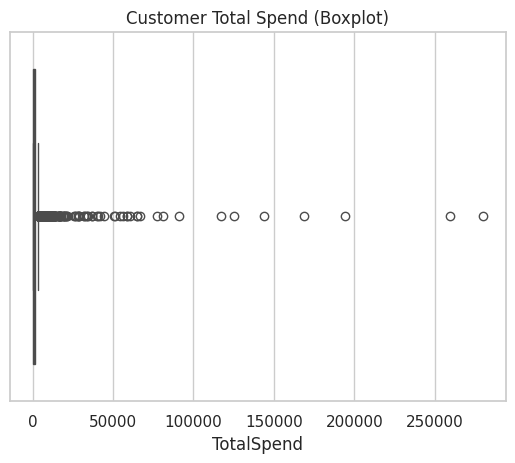

In [17]:
sns.boxplot(x=customer_level['TotalSpend'])
plt.title('Customer Total Spend (Boxplot)')
plt.show()

## Repeat Purchase Analysis

Repeat customers are a key indicator of retention and long-term business value. This section compares repeat and one-time customers.


In [18]:
customer_level['RepeatCustomer'].value_counts(normalize=True)

,proportion
RepeatCustomer,
True,0.655832
False,0.344168


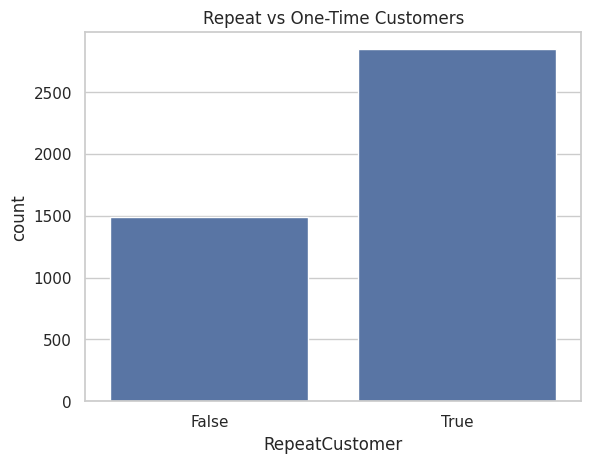

In [19]:
sns.countplot(x='RepeatCustomer', data=customer_level)
plt.title('Repeat vs One-Time Customers')
plt.show()

In [20]:
customer_level.groupby('RepeatCustomer')['TotalSpend'].mean()

,TotalSpend
RepeatCustomer,
False,411.245520
True,2907.985706


## Customer Value Segmentation

Customers are segmented into value tiers based on spending behavior to support targeted engagement strategies.


In [21]:
# ValueSegment already created in the customer_level table above
customer_level['ValueSegment'].value_counts()

,count
ValueSegment,
Low Value,1446
Medium Value,1446
High Value,1446


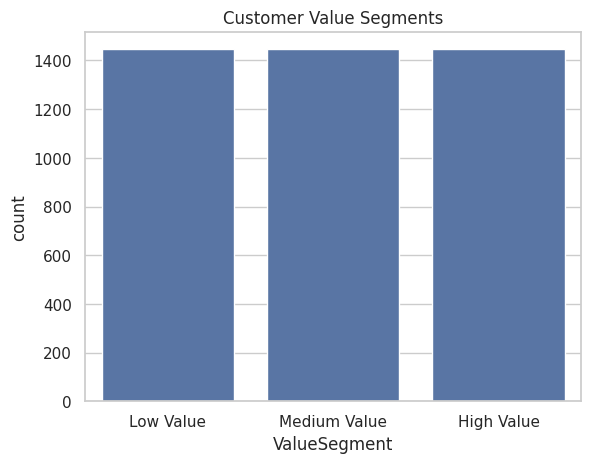

In [22]:
sns.countplot(x='ValueSegment', data=customer_level)
plt.title('Customer Value Segments')
plt.show()

## Key Insights

- The customer base is concentrated within specific age groups, indicating clear target demographics.
- Repeat customers generate significantly higher average spending compared to one-time customers.
- High-value customers represent a smaller portion of the customer base but contribute disproportionately to revenue.
- Certain regions show strong engagement but lower spending, indicating upsell opportunities.


## Business Recommendations

- Focus retention campaigns on repeat and high-value customers to maximize lifetime value.
- Design targeted promotions for medium-value customers to encourage repeat purchases.
- Use demographic insights to personalize marketing strategies by age group and region.
- Implement loyalty programs to convert one-time customers into repeat buyers.
